In [1]:
# Headers
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from copy import deepcopy
from skimage.feature import greycomatrix, greycoprops
import cv2  
from numpy.linalg import det
from skimage import util, exposure
from math import sqrt, ceil
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from time import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
# global variables
black_value = np.float64(-1408.5106382978724)
images_filename = 'tr_im.nii'
masks_filename = 'tr_mask.nii'

In [3]:
def get_vals(mask):
    vals = []
    x, y = mask.shape
    for i in range(x):
        for j in range(y):
            if mask[i,j] not in vals:
                vals.append(mask[i][j])

    vals.remove(0)
    return vals

In [15]:
def apply_mask(img, mask, class_id):
    heigh, width = img.shape
    tmp = deepcopy(img)
    lineal_array = []
    for x in range(heigh):
        for y in range(width):
            # Set pixel as black color if is not inside this mask
            if mask[x,y] != np.float64(class_id):
                tmp[x,y] = black_value
            # Count pixels inside this mask
            else:
                lineal_array.append([tmp[x,y]])
    # In tmp is saved the image with mask applied
    # In lineal_array is saved just the mask's pixels
    return tmp, lineal_array

In [16]:
def calculate_media_lineal_arr(array):
    length = array.shape[0]
    media = np.float64(0)
    for x in range(length):
        media += array[x]
    media = media/length
    return media

In [17]:
def show_slice_mask(slicei, mask):
    """ Function to display images and mask """
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(slicei.T,  cmap="gray", origin="lower")
    ax[0].set_title('Image')
    ax[1].imshow(mask.T, cmap="gray", origin="lower")
    ax[1].set_title('Mask')
    plt.show()

In [18]:
def trainingKnn(imgs, masks):
    height, width, num_images = imgs.shape
    
    X = []
    Y = []
    # loop over the images
    for x in range(num_images):
        if (x+1) % 10 == 0:
            print("{} imagenes procesadas".format(x+1))
        # Get every class in the current image
        classes = get_vals(masks[:,:,x])
        # loop for every class in the current image 
        for j in classes:
            # getting the square matrix for the current class
            tmp, pixels = apply_mask(imgs[:,:,x], masks[:,:,x], j)
            # Contrast, Correlation, Energy properties
            X = X + pixels
            Y = Y + [int(j) for x in range(len(pixels))]

    return (X, Y)

In [19]:
imgs = nib.load(images_filename).get_fdata()
masks = nib.load(masks_filename).get_fdata()
print("training KNN")
X, Y = trainingKnn(imgs, masks)

training KNN
10 imagenes procesadas
20 imagenes procesadas
30 imagenes procesadas
40 imagenes procesadas
50 imagenes procesadas
60 imagenes procesadas
70 imagenes procesadas
80 imagenes procesadas
90 imagenes procesadas
100 imagenes procesadas


In [28]:
def classifier():
    imgs = nib.load(images_filename).get_fdata()
    masks = nib.load(masks_filename).get_fdata()
    #print("training KNN")
    #X, Y = trainingKnn(imgs, masks)
    # neighbors equals to number os classes
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X, Y)
    bay = GaussianNB()
    bay.fit(X, Y)
    print("Done")
    tmp = np.zeros((512,512))
    count = 0
    for n in range(4,5):
        print("\nImage no ", n)
        show_slice_mask(imgs[:,:,n], masks[:,:,n])
        print("Start classifiying every pixel")
        height, width = imgs[:,:,n].shape
        for x in range(height):
            for y in range(width):
                if (x*y+1) % 52428 == 0:
                    print("Working {}% ".format((x*y+1)/262.144))

                #print(neigh.predict_proba([[imgs[x,y,n]]]))
                #print(bay.predict_proba([[imgs[x,y,n]]]))
                if neigh.predict([[imgs[x,y,n]]])[0] == bay.predict([[imgs[x,y,n]]])[0]:
                    count +=1
                    tmp[x,y] = imgs[x,y,n]
                    #show_slice_mask(tmp,superpixels[k])
        show_slice_mask(imgs[:,:,n],tmp)
        print(count)

Done

Image no  4


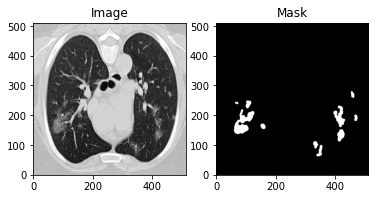

Start classifiying every pixel
Working 0.1999969482421875% 
Working 0.399993896484375% 
Working 0.399993896484375% 
Working 0.1999969482421875% 


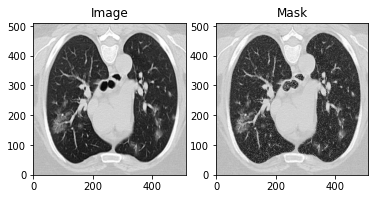

240969


In [29]:
classifier()